In [ ]:
# !pip install nilearn
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

In [59]:
from nilearn import datasets, image, masking, plotting, regions
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA
from nilearn.image import new_img_like
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

In [6]:
# load a two file from two subjects
file_path_1 = '../FMRI/derivatives/sub-EN057/func/sub-EN057_task-lppEN_run-15_space-MNIColin27_desc-preproc_bold.nii.gz'
file_path_2 = '../FMRI/derivatives/sub-EN058/func/sub-EN058_task-lppEN_run-08_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_1  = image.load_img(file_path_1)
nii_data_1 = nii_img_1.get_fdata()
nii_img_2  = image.load_img(file_path_2)
nii_data_2 = nii_img_2.get_fdata()

In [7]:
print(nii_img_1.header.get_zooms())
print(nii_img_1.header.get_xyzt_units())

(2.0, 2.0, 2.0, 2.0)
('mm', 'sec')


In [8]:
nii_data_1.shape

(73, 90, 74, 282)

In [9]:
nii_data_2.shape

(73, 90, 74, 282)

## RSA sentence by sentence analysis

In [112]:
def rsa_function(file_path, N_components=282):

    '''
    Compute the sen by sen RSA with cosine similarity
    '''

    nii_img  = image.load_img(file_path)
    nii_data = nii_img.get_fdata()

    time_series = nii_data.transpose(3,0,1,2).reshape(nii_data.shape[3],-1)

    N_components = min(N_components, len(time_series))
    pca = PCA(N_components)
    pca.fit(time_series)
    # print('Explained variance:', pca.explained_variance_ratio_)

    nii_data_pca = pca.transform(time_series)

    # discard 5 first scans because we don't have words for them
    nii_data_pca = nii_data_pca[5:,:]

    # compute the RSA as sentence by sentence cosine sim matrix
    nii_data_pca.shape
    RSA = sp.spatial.distance.cdist(nii_data_pca, nii_data_pca, metric='cosine')
    RSA = RSA/RSA.max()

    return RSA


In [76]:
RSA_1 = rsa_function(file_path_1)
RSA_2 = rsa_function(file_path_2)

(277, 282)
(277, 282)


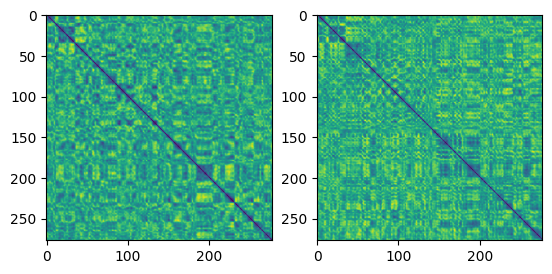

In [79]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(RSA_1)
ax[1].imshow(RSA_2)

## RSA by RSA correlation

In [113]:
def rsa_correlation(RSA_1, RSA_2):
    '''
    computes the correlation between to RSA matrizes with pearson correlation
    '''
    RSA_upper_1 = np.triu(RSA_1, 5)
    RSA_upper_2 = np.triu(RSA_2, 5)
    RSA_up_1 = RSA_upper_1[RSA_upper_1 !=0]
    RSA_up_2 = RSA_upper_2[RSA_upper_2 !=0]

    Corr = sp.stats.pearsonr(RSA_up_1.flatten(), RSA_up_2.flatten())

    return Corr

In [80]:
Corr = rsa_correlation(RSA_1, RSA_2)

Pearson correlation coefficient between RSA1 and RSA2: PearsonRResult(statistic=0.11280208834677859, pvalue=2.111996252190469e-105)


## Analysis of all subjects

Load all the subject data

In [87]:
# for now we only take the first scan for each subject
scans = {}
path_to_data = f'../FMRI/derivatives/'
path_to_subjects = [it.path for it in os.scandir(path_to_data)]
for subject_path in path_to_subjects:
    # extract name of the subject
    subject = subject_path[subject_path.find('sub-') + 4 : subject_path.find('sub-') + 9]
    # take the first scan of the subject
    path_to_scans = [it.path for it in os.scandir(subject_path + '/func/')]
    scans[subject] = path_to_scans[0]
print(len(scans))

111


### Compute RSAs for first scan of every subject

In [ ]:
# # check if it can load the files
# for i, subject in enumerate(scans.keys()):
#     print(scans[subject])
#     print(i)
#     if i == 16: continue
#     if i == 17: continue
#     img  = image.load_img(scans[subject])


In [95]:
# should take over an hour (appr. 40 sec per subj, n_subj=111)
RSAs = {}
for i, subject in enumerate(scans.keys()):
    if i % 10 == 0: print(f'Running subject {i}')
    try:
        RSAs[subject] = rsa_function(scans[subject])
    except EOFError:
        print(scans[subject])
        continue

Running subject 0
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
Running subject 10
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
../FMRI/derivatives/sub-CN018/func/sub-CN018_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
../FMRI/derivatives/sub-CN019/func/sub-CN019_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
(278, 282)
(278, 282)
Running subject 20
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
Running subject 30
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(278, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
Running subject 40
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
Running subject 50
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
(277, 282)
Running subject 60
(277, 282)
(277, 282

In [100]:
import json

RSAs_list = {}
for key, value in RSAs.items():
    RSAs_list[key] = value.tolist()

with open("RSAs_first_scan_per_subject.json", "w") as f:
    json.dump(RSAs_list, f)

### Load RSAs and compute pairwise pearson correlation

In [101]:
# load the dictionary from the JSON file
with open('RSAs_first_scan_per_subject.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs = {}
for key, value in RSAs_list.items():
    RSAs[key] = np.array(value)

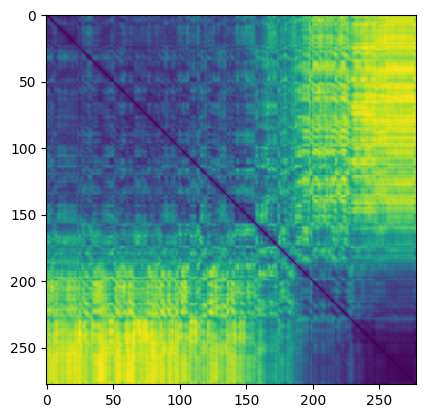

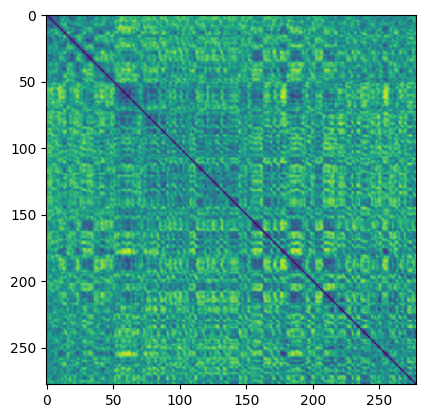

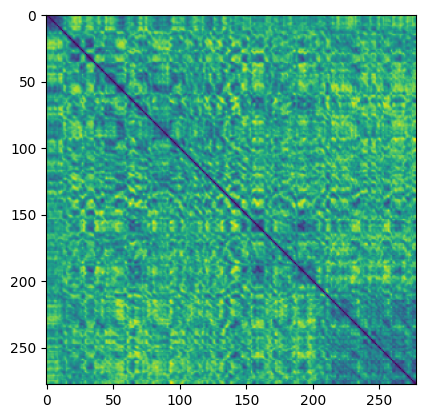

In [107]:
count = 0
for key, value in RSAs.items():
    plt.figure(count)
    plt.imshow(value)
    count += 1
    if count == 3: break

In [115]:
N_subjects = len(scans) 
Correlations = np.zeros((N_subjects, N_subjects))
pvalues = np.zeros((N_subjects, N_subjects))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs.keys()):
    for j, subj_b in enumerate(RSAs.keys()):
        rsa_1 = RSAs[subj_a]
        rsa_2 = RSAs[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        Correlations[i,j], pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {Correlations[i,j]}, pvalue: {pvalues[i,j]}")

Pearson correlation coefficient between CN001 and CN001: 0.9999999999999999, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN002: 0.0793898027745779, pvalue: 2.327144196306951e-53
Pearson correlation coefficient between CN001 and CN003: 0.21511384435663736, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN004: 0.09857659023024773, pvalue: 2.0854922915490323e-81
Pearson correlation coefficient between CN001 and CN005: 0.5670206423971401, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN006: 0.09639031914912037, pvalue: 6.663912285090086e-78
Pearson correlation coefficient between CN001 and CN007: 0.09006200208284112, pvalue: 3.3072302743648247e-68
Pearson correlation coefficient between CN001 and CN008: 0.01582744422090572, pvalue: 0.0022058997922179274
Pearson correlation coefficient between CN001 and CN009: 0.2533735598433391, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN010: 0.0773796673480377, pvalue: 8.971638546773717

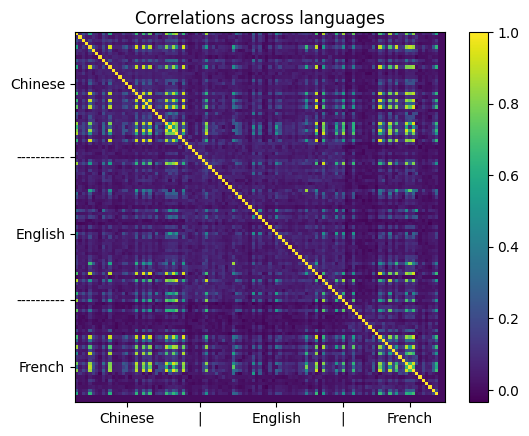

In [130]:
plt.figure(42)
plt.title('Correlations across languages')
plt.xticks([15, 37, 60 ,80, 100], ['Chinese', '|', 'English', '|', 'French'])
plt.yticks([15, 37, 60 ,80, 100], ['Chinese', '----------', 'English', '----------', 'French'])
plt.imshow(Correlations)
plt.colorbar()

## Trial Analysis

In [47]:
time_series_p1 = nii_data_1.transpose(3,0,1,2).reshape(nii_data_1.shape[3],-1)
print(time_series_p1.shape)
time_series_p2 = nii_data_2.transpose(3,0,1,2).reshape(nii_data_2.shape[3],-1)
print(time_series_p2.shape)

(282, 486180)
(282, 486180)


In [74]:
N = 10
transformed_time_series = []

for time_series_subj in [time_series_p1, time_series_p2]:

    pca = PCA(N)
    pca.fit(time_series_subj)
    print('Explained variance:', pca.explained_variance_ratio_)

    time_series_subj_pca = pca.transform(time_series_subj)
    time_series_subj_t = pca.inverse_transform(time_series_subj_pca)
    print(time_series_subj_t.shape)
    
    transformed_time_series.append(time_series_subj_t)

Explained variance: [0.11738748 0.10352329 0.09724053 0.06600865 0.04404133 0.03873402
 0.02957861 0.02763606 0.02074258 0.01873538]
(282, 486180)
Explained variance: [0.13900891 0.12934915 0.09585001 0.0581043  0.05315918 0.04618975
 0.03417909 0.03102534 0.02234069 0.02096533]
(282, 486180)


First get the mask

(282, 207632)

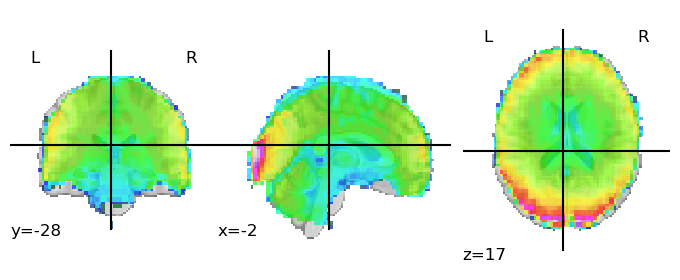

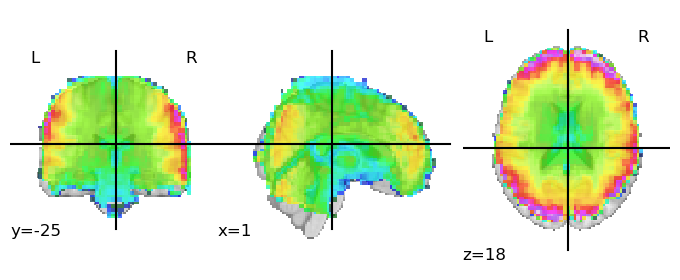

In [80]:
p1 = transformed_time_series[0]
p2 = transformed_time_series[1]

# Reshape the PCA-transformed data back into a 4D array
p1_4d = np.reshape(p1.T, nii_data_1.shape)

# Create a new Nifti image with the PCA-transformed data and the same header as the original image
p1_pca_img = new_img_like(nii_img_1, p1_4d, affine=nii_img_1.affine)

func_mean = image.mean_img(p1_pca_img)
display = plotting.plot_roi(func_mean)

func_mask = masking.compute_epi_mask(func_mean)
nii1_masked = masking.apply_mask(p1_pca_img, func_mask)
nii1_masked.shape

# Reshape the PCA-transformed data back into a 4D array
p2_4d = np.reshape(p2.T, nii_data_2.shape)

# Create a new Nifti image with the PCA-transformed data and the same header as the original image
p2_pca_img = new_img_like(nii_img_2, p2_4d, affine=nii_img_2.affine)

func_mean2 = image.mean_img(p2_pca_img)
display = plotting.plot_roi(func_mean2)

func_mask2 = masking.compute_epi_mask(func_mean2)
nii2_masked = masking.apply_mask(p2_pca_img, func_mask2)
nii2_masked.shape

## Brain Regions Analysis

[(1, 'Background'), (2, 'Frontal Pole'), (3, 'Insular Cortex'), (4, 'Superior Frontal Gyrus'), (5, 'Middle Frontal Gyrus'), (6, 'Inferior Frontal Gyrus, pars triangularis'), (7, 'Inferior Frontal Gyrus, pars opercularis'), (8, 'Precentral Gyrus'), (9, 'Temporal Pole'), (10, 'Superior Temporal Gyrus, anterior division'), (11, 'Superior Temporal Gyrus, posterior division'), (12, 'Middle Temporal Gyrus, anterior division'), (13, 'Middle Temporal Gyrus, posterior division'), (14, 'Middle Temporal Gyrus, temporooccipital part'), (15, 'Inferior Temporal Gyrus, anterior division'), (16, 'Inferior Temporal Gyrus, posterior division'), (17, 'Inferior Temporal Gyrus, temporooccipital part'), (18, 'Postcentral Gyrus'), (19, 'Superior Parietal Lobule'), (20, 'Supramarginal Gyrus, anterior division'), (21, 'Supramarginal Gyrus, posterior division'), (22, 'Angular Gyrus'), (23, 'Lateral Occipital Cortex, superior division'), (24, 'Lateral Occipital Cortex, inferior division'), (25, 'Intracalcarine C

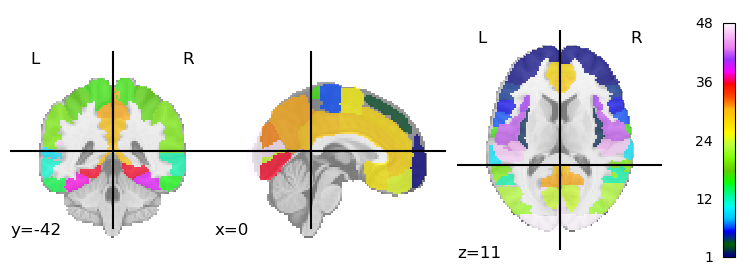

In [81]:
ho_maxprob_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
ho_maxprob_atlas_img = image.load_img(ho_maxprob_atlas['maps'])

# ROI numbers & text labels in this atlas
print([(i+1, roi) for i, roi in enumerate(ho_maxprob_atlas['labels'])])
display = plotting.plot_roi(ho_maxprob_atlas_img, colorbar=True)

In [83]:
# resample the atlas to the dataset resolution
ho_maxprob_atlas_img_resamp1 = image.resample_to_img(
    ho_maxprob_atlas_img,
    target_img=p1_pca_img,
    interpolation='nearest'
)
ho_maxprob_atlas_img_resamp2 = image.resample_to_img(
    ho_maxprob_atlas_img,
    target_img=p2_pca_img,
    interpolation='nearest'
)

In [85]:
# reduce data to get mean signal for each ROI
av_roi_data1 = regions.img_to_signals_labels(
    p1_pca_img,
    labels_img=ho_maxprob_atlas_img_resamp1,
    background_label=0
)
av_roi_data2 = regions.img_to_signals_labels(
    p2_pca_img,
    labels_img=ho_maxprob_atlas_img_resamp2,
    background_label=0
)

In [87]:
print(av_roi_data1[0].shape)
print(av_roi_data2[0].shape)

(282, 48)
(282, 48)
